In [1]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA,FactorAnalysis
import glob
from sncosmo.salt2utils import BicubicInterpolator
from matplotlib.ticker import ScalarFormatter
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split
import sncosmo
from scipy.interpolate import interp1d
from numpy import random
import pickle as pk
from astropy.table import Table
from sncosmo.constants import HC_ERG_AA
from sklearn import preprocessing
from scipy.linalg import block_diag
from pathlib import Path
from scipy.stats import ks_2samp

SCALE_FACTOR = 1e-12

In [3]:
# FA class from sklearn does not perfom complete Scaling (i.e. transform the data to zero mean and unit variance column(features) wise)
# This class perfom only centering by mean, column wise. 

In [4]:
plt.rcParams['font.size'] = 20.

In [5]:
class ScalarFormatterClass1(ScalarFormatter):
    def _set_format(self):
        self.format = "%1.1f"

In [6]:
p_grid=np.arange(-10,51,1)
w_grid_reg=np.arange(3310,8585,10) 

In [7]:
X, Y=np.meshgrid(p_grid,w_grid_reg)

## Retrieve Data and Define Train/Validation samples

In [8]:
snnames=[]
for file in glob.glob("../Applying_GPy/SEDs_reg_normalized/*.dat"):
    snnames.append(file.split("/")[3].split(".")[0])

In [9]:
len(snnames)

166

In [10]:
val_sn, train_sn=train_test_split(snnames, test_size=0.9, train_size=0.1, random_state=0)

In [11]:
train_names=[]
train_data=[]
train_data_err=[]

In [12]:
val_names=[]
val_data=[]
val_data_err=[]

In [13]:
for sn in snnames:
    if sn in val_sn:
        val_data.append(pd.read_csv(f"../Applying_GPy/SEDs_reg_normalized/{sn}.dat")["flux"].values)
        val_data_err.append(pd.read_csv(f"../Applying_GPy/SEDs_reg_normalized/{sn}.dat")["fluxerr"].values)
        val_names.append(sn)
    else:
        train_data.append(pd.read_csv(f"../Applying_GPy/SEDs_reg_normalized/{sn}.dat")["flux"].values)
        train_data_err.append(pd.read_csv(f"../Applying_GPy/SEDs_reg_normalized/{sn}.dat")["fluxerr"].values)
        train_names.append(sn)

In [14]:
val_names

['Train_SN51_v2_SED_normalized',
 'Test_SN23_v2_SED_normalized',
 'Test_SN44_v2_SED_normalized',
 'Test_SN8_v2_SED_normalized',
 'Train_SN106_v2_SED_normalized',
 'Train_SN78_v2_SED_normalized',
 'Test_SN21_v2_SED_normalized',
 'Train_SN53_v2_SED_normalized',
 'Test_SN39_v2_SED_normalized',
 'Train_SN95_v2_SED_normalized',
 'Test_SN42_v2_SED_normalized',
 'Train_SN121_v2_SED_normalized',
 'Train_SN83_v2_SED_normalized',
 'Train_SN115_v2_SED_normalized',
 'Train_SN116_v2_SED_normalized',
 'Train_SN108_v2_SED_normalized']

In [15]:
train_names

['Test_SN2_v2_SED_normalized',
 'Train_SN6_v2_SED_normalized',
 'Train_SN68_v2_SED_normalized',
 'Test_SN29_v2_SED_normalized',
 'Train_SN37_v2_SED_normalized',
 'Test_SN20_v2_SED_normalized',
 'Train_SN90_v2_SED_normalized',
 'Train_SN105_v2_SED_normalized',
 'Train_SN55_v2_SED_normalized',
 'Train_SN3_v2_SED_normalized',
 'Train_SN9_v2_SED_normalized',
 'Test_SN47_v2_SED_normalized',
 'Train_SN56_v2_SED_normalized',
 'Train_SN94_v2_SED_normalized',
 'Test_SN32_v2_SED_normalized',
 'Train_SN5_v2_SED_normalized',
 'Train_SN62_v2_SED_normalized',
 'Train_SN24_v2_SED_normalized',
 'Train_SN91_v2_SED_normalized',
 'Train_SN52_v2_SED_normalized',
 'Test_SN7_v2_SED_normalized',
 'Test_SN43_v2_SED_normalized',
 'Test_SN18_v2_SED_normalized',
 'Test_SN46_v2_SED_normalized',
 'Train_SN69_v2_SED_normalized',
 'Train_SN99_v2_SED_normalized',
 'Train_SN54_v2_SED_normalized',
 'Train_SN101_v2_SED_normalized',
 'Train_SN21_v2_SED_normalized',
 'Test_SN17_v2_SED_normalized',
 'Train_SN19_v2_SED_norm

## Reading FA

In [16]:
M_fa2=[]
noise_var_fa2=[]

In [17]:
noise_var_fa2=pd.read_csv(f"./fa_components/fa2/noise_variance_fa2.txt",header=None).values
for i in range(0,2+1):
    M_fa2.append(pd.read_csv(f"./fa_components/fa2/M{i}_fa2.txt",header=None).values.reshape(-1))

In [18]:
M_fa5=[]
noise_var_fa5=[]

In [19]:
noise_var_fa5=pd.read_csv(f"./fa_components/fa5/noise_variance_fa5.txt",header=None).values
for i in range(0,5+1):
    M_fa5.append(pd.read_csv(f"./fa_components/fa5/M{i}_fa5.txt",header=None).values.reshape(-1))

## View FA2 Components

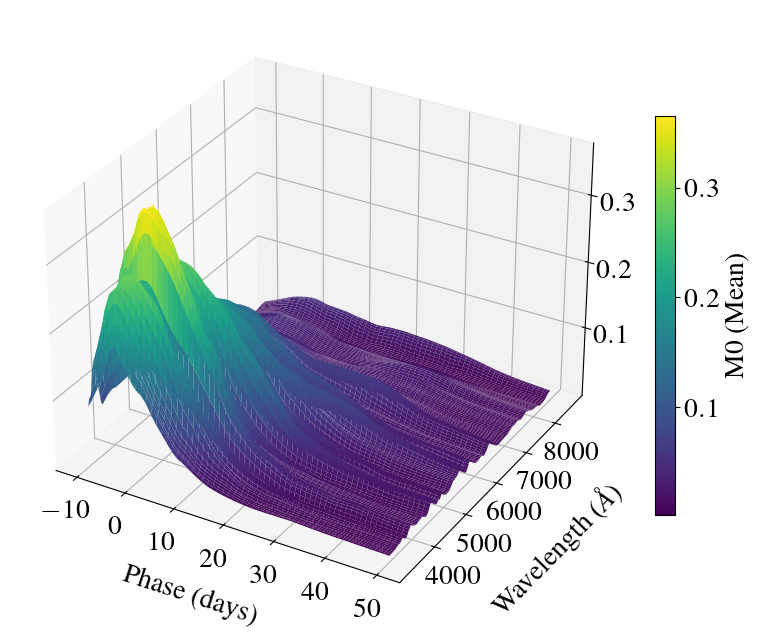

In [20]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,M_fa2[0].reshape(X.shape),cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel("Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
fig.colorbar(g, ax=ax,fraction=0.03, label="M0 (Mean)")
fig.tight_layout()
plt.savefig('./fa_figures/M0(mean).png', facecolor="white")  

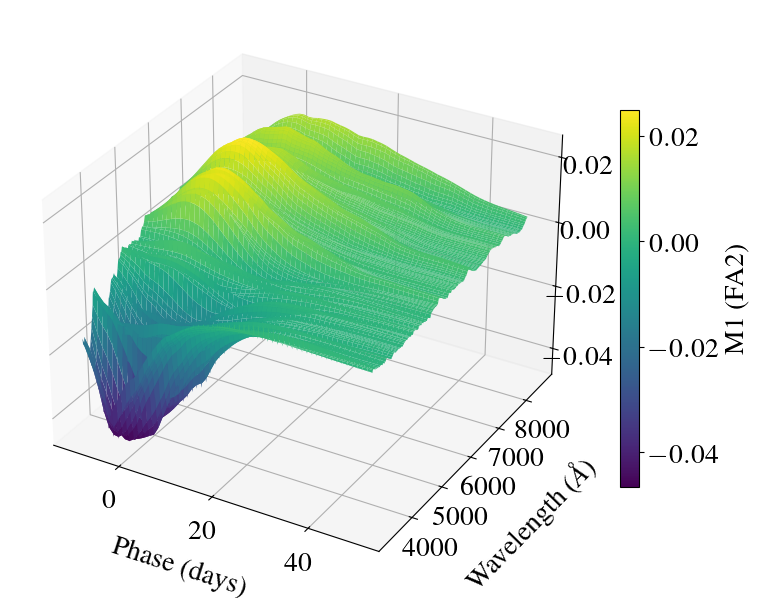

In [21]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,M_fa2[1].reshape(X.shape),cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel("Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
fig.colorbar(g, ax=ax,fraction=0.03, label="M1 (FA2)")
fig.tight_layout()
plt.savefig('./fa_figures/M1(FA2).png', facecolor="white")  

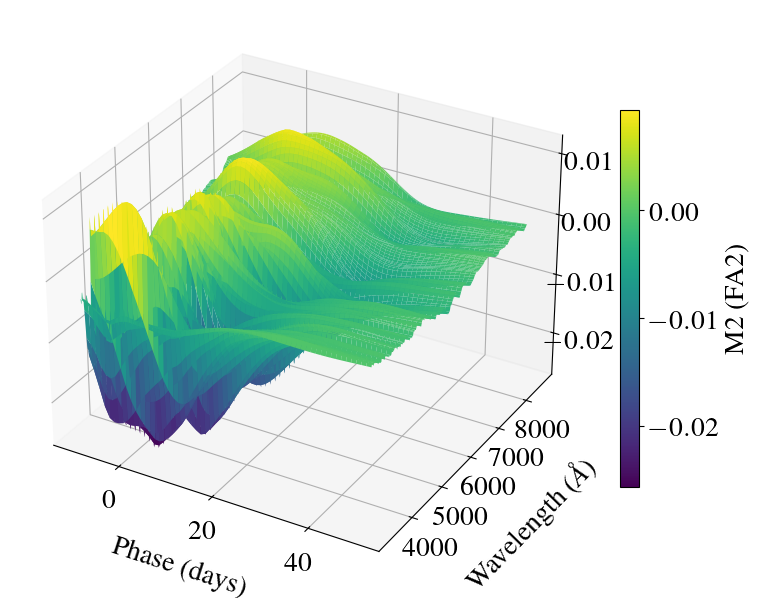

In [22]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,M_fa2[2].reshape(X.shape),cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel("Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
fig.colorbar(g, ax=ax,fraction=0.03, label="M2 (FA2)")
fig.tight_layout()
plt.savefig('./fa_figures/M2(FA2).png', facecolor="white")  

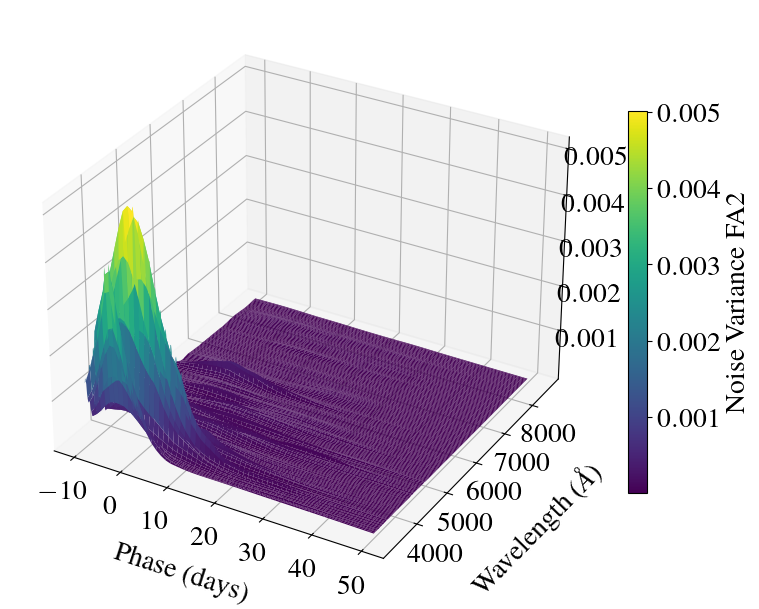

In [23]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,noise_var_fa2.reshape(X.shape),cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel("Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
fig.colorbar(g, ax=ax,fraction=0.03, label="Noise Variance FA2")
fig.tight_layout()
#plt.savefig('./fa_figures/noise_variance_fa2.png', facecolor="white")  

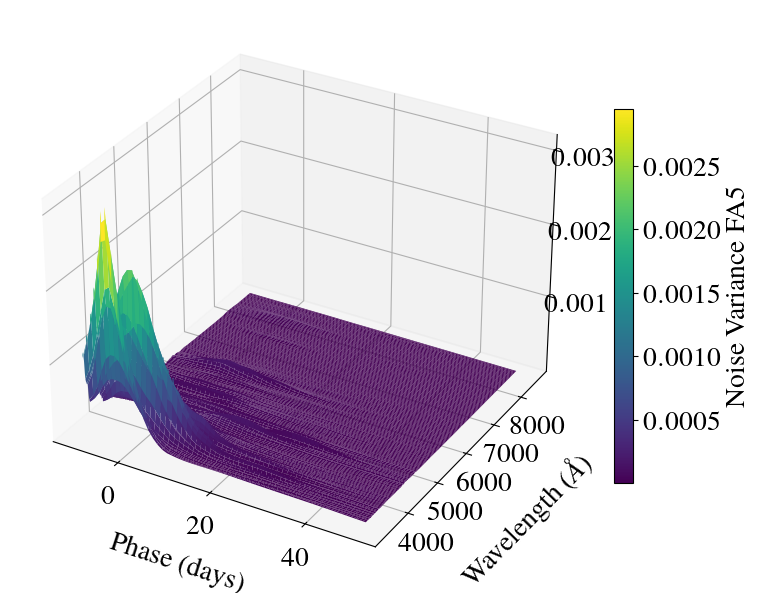

In [24]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,noise_var_fa5.reshape(X.shape),cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel("Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
fig.colorbar(g, ax=ax,fraction=0.03, label="Noise Variance FA5")
fig.tight_layout()
#plt.savefig('./fa_figures/noise_variance_fa5.png', facecolor="white")  

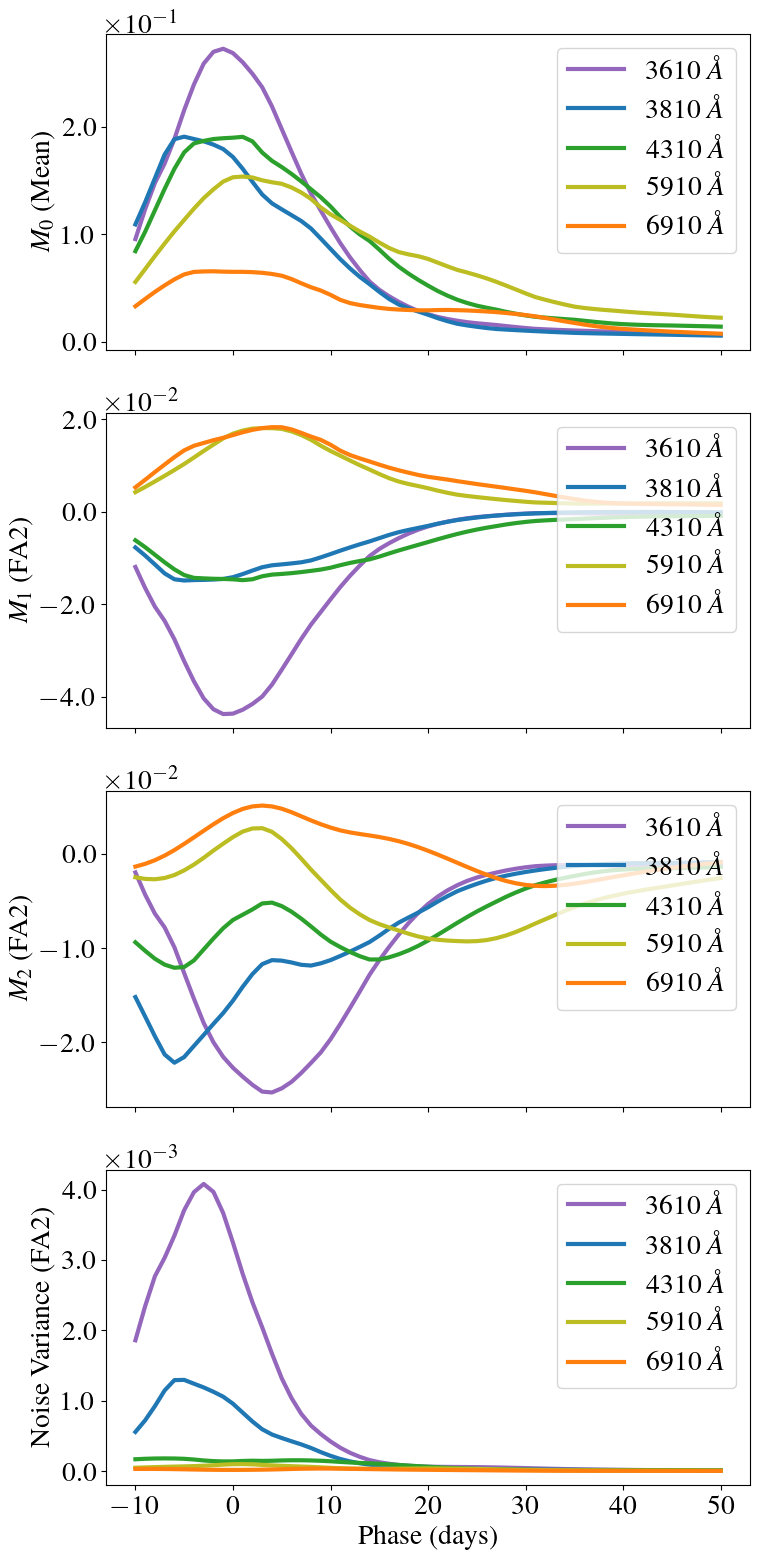

In [25]:
fig, axs = plt.subplots(4,1,figsize=(8,16),sharex=True)

colors=["C4","C0","C2","C8","C1","C3"]
for j,i in enumerate([30,50,100,260,360]):
    axs[0].plot(X[i],M_fa2[0].reshape(X.shape)[i],label=f"{int(Y[i][0])} $\\AA$",lw=3,color=colors[j])
    axs[0].set_ylabel(r"$M_0$ (Mean)")
    #ax1.set_title("First Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[0].yaxis.set_major_formatter(formatter11)
    axs[0].legend(loc=1)

for j,i in enumerate([30,50,100,260,360]):
    axs[1].plot(X[i],M_fa2[1].reshape(X.shape)[i],label=f"{int(Y[i][0])} $\\AA$",lw=3,color=colors[j])
    axs[1].set_ylabel(r"$M_1$ (FA2)")
    #ax2.set_title("Second Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[1].yaxis.set_major_formatter(formatter11)
    axs[1].legend(loc=1)

for j,i in enumerate([30,50,100,260,360]):
    axs[2].plot(X[i],M_fa2[2].reshape(X.shape)[i],label=f"{int(Y[i][0])} $\\AA$",lw=3,color=colors[j])
    axs[2].set_ylabel(r"$M_2$ (FA2)")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[2].yaxis.set_major_formatter(formatter11)
    axs[2].legend(loc=1)

for j,i in enumerate([30,50,100,260,360]):
    axs[3].plot(X[i],noise_var_fa2.reshape(X.shape)[i],label=f"{int(Y[i][0])} $\\AA$",lw=3,color=colors[j])
    axs[3].set_xlabel("Phase (days)")
    axs[3].set_ylabel(r"Noise Variance (FA2)")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[3].yaxis.set_major_formatter(formatter11)
    axs[3].legend(loc=1)
    
fig.tight_layout()
plt.savefig('./fa_figures/FA_components.png',dpi=300,facecolor='white', transparent=False,bbox_inches='tight')  

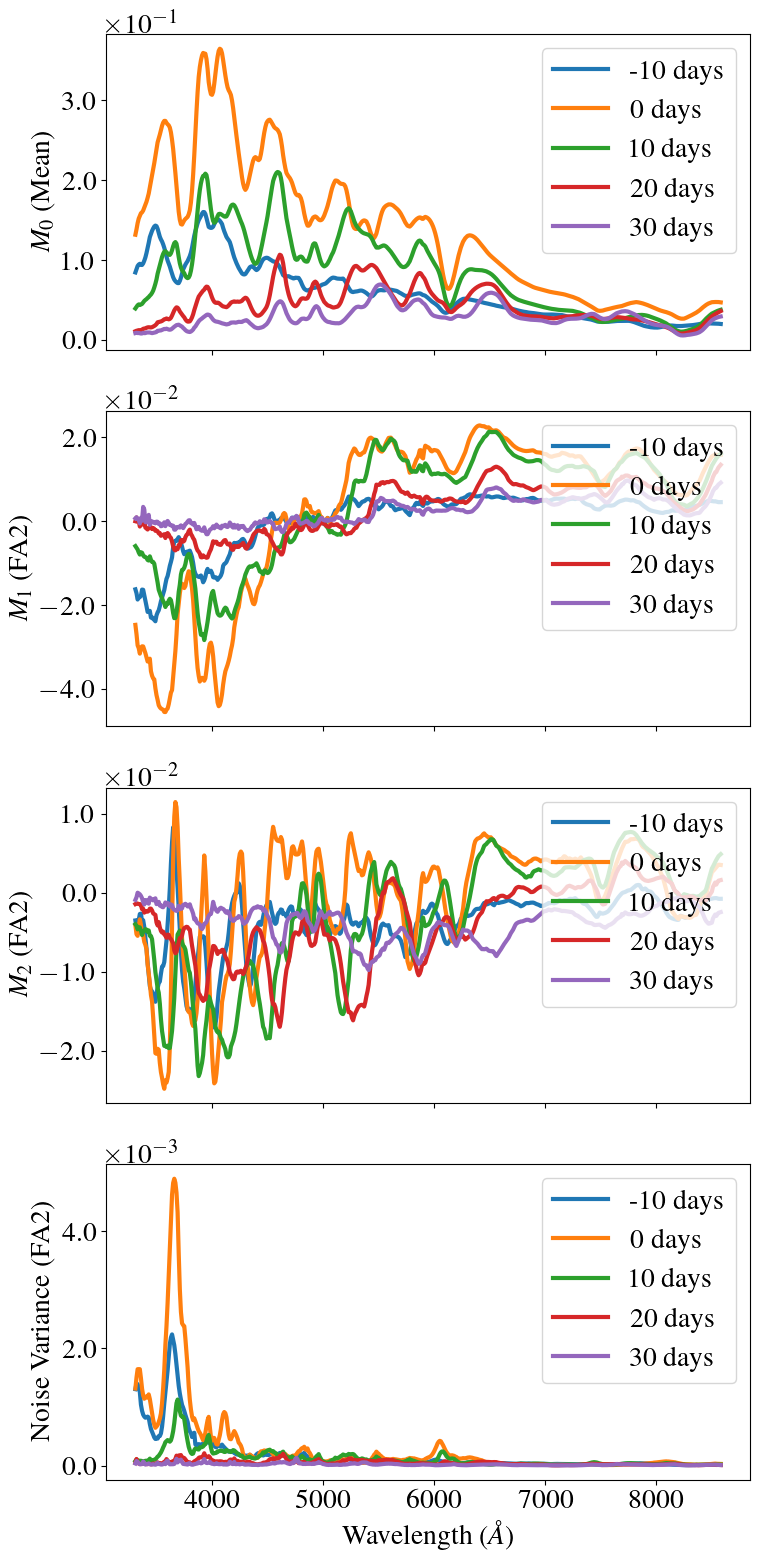

In [26]:
fig, axs = plt.subplots(4,1,figsize=(8,16),sharex=True)

colors=["C0","C1","C2","C3","C4","C5"]
for j,i in enumerate([0,10,20,30,40]):
    axs[0].plot(Y.T[i],M_fa2[0].reshape(X.shape).T[i],label=f"{int(X.T[i][0])} days",lw=3,color=colors[j])
    axs[0].set_ylabel(r"$M_0$ (Mean)")
    #ax1.set_title("First Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[0].yaxis.set_major_formatter(formatter11)
    axs[0].legend(loc=1)

for j,i in enumerate([0,10,20,30,40]):
    axs[1].plot(Y.T[i],M_fa2[1].reshape(X.shape).T[i],label=f"{int(X.T[i][0])} days",lw=3,color=colors[j])
    axs[1].set_ylabel(r"$M_1$ (FA2)")
    #ax2.set_title("Second Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[1].yaxis.set_major_formatter(formatter11)
    axs[1].legend(loc=1)

for j,i in enumerate([0,10,20,30,40]):
    axs[2].plot(Y.T[i],M_fa2[2].reshape(X.shape).T[i],label=f"{int(X.T[i][0])} days",lw=3,color=colors[j])
    axs[2].set_ylabel(r"$M_2$ (FA2)")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[2].yaxis.set_major_formatter(formatter11)
    axs[2].legend(loc=1)

for j,i in enumerate([0,10,20,30,40]):
    axs[3].plot(Y.T[i],noise_var_fa2.reshape(X.shape).T[i],label=f"{int(X.T[i][0])} days",lw=3,color=colors[j])
    axs[3].set_xlabel(r"Wavelength ($\AA$)")
    axs[3].set_ylabel("Noise Variance (FA2)")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[3].yaxis.set_major_formatter(formatter11)
    axs[3].legend(loc=1)

fig.tight_layout()
plt.savefig('./fa_figures/FA_components_wave.png',dpi=300,facecolor='white', transparent=False,bbox_inches='tight')  

In [27]:
M0_g=[]
M0_b=[]
M0_v=[]
M0_r=[]
for d in range(len(X.T)):
    sp=sncosmo.Spectrum(wave=Y.T[d], flux=M_fa2[0].reshape(X.shape).T[d],time=X.T[d][0]) 
    M0_g.append(sp.bandflux("cspg"))
    M0_b.append(sp.bandflux("cspb"))
    M0_v.append(sp.bandflux("cspv9844"))
    M0_r.append(sp.bandflux("cspr"))

In [28]:
M1_g=[]
M1_b=[]
M1_v=[]
M1_r=[]
for d in range(len(X.T)):
    sp=sncosmo.Spectrum(wave=Y.T[d], flux=M_fa2[1].reshape(X.shape).T[d],time=X.T[d][0]) 
    M1_g.append(sp.bandflux("cspg"))
    M1_b.append(sp.bandflux("cspb"))
    M1_v.append(sp.bandflux("cspv9844"))
    M1_r.append(sp.bandflux("cspr"))

In [29]:
M2_g=[]
M2_b=[]
M2_v=[]
M2_r=[]
for d in range(len(X.T)):
    sp=sncosmo.Spectrum(wave=Y.T[d], flux=M_fa2[2].reshape(X.shape).T[d],time=X.T[d][0]) 
    M2_g.append(sp.bandflux("cspg"))
    M2_b.append(sp.bandflux("cspb"))
    M2_v.append(sp.bandflux("cspv9844"))
    M2_r.append(sp.bandflux("cspr"))

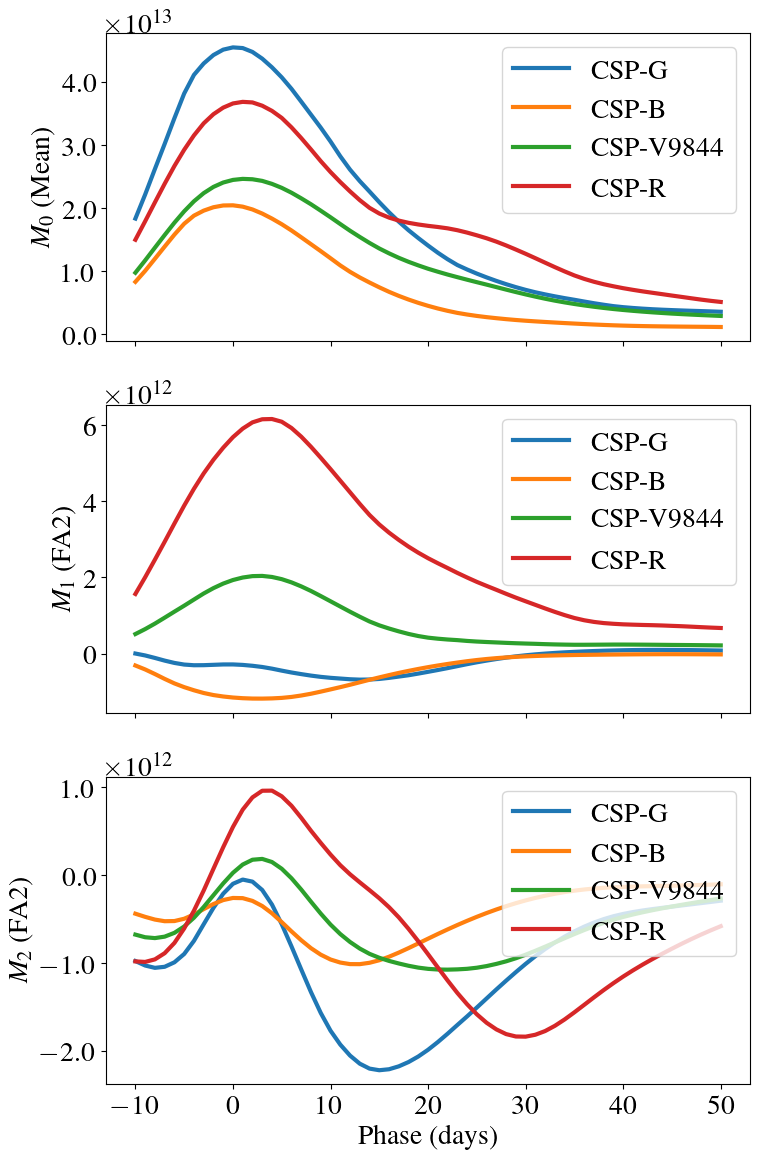

In [30]:
fig, axs = plt.subplots(3,1,figsize=(8,12),sharex=True)

colors=["C0","C1","C2","C3","C4","C5"]

axs[0].plot(X[0],M0_g,label=f"CSP-G",lw=3,color=colors[0])
axs[0].plot(X[0],M0_b,label=f"CSP-B",lw=3,color=colors[1])
axs[0].plot(X[0],M0_v,label=f"CSP-V9844",lw=3,color=colors[2])
axs[0].plot(X[0],M0_r,label=f"CSP-R",lw=3,color=colors[3])
axs[0].set_ylabel(r"$M_0$ (Mean)")
formatter11=ScalarFormatterClass1()
formatter11.set_scientific(True)
formatter11.set_powerlimits((0,0))
axs[0].yaxis.set_major_formatter(formatter11)
axs[0].legend(loc=1)

axs[1].plot(X[0],M1_g,label=f"CSP-G",lw=3,color=colors[0])
axs[1].plot(X[0],M1_b,label=f"CSP-B",lw=3,color=colors[1])
axs[1].plot(X[0],M1_v,label=f"CSP-V9844",lw=3,color=colors[2])
axs[1].plot(X[0],M1_r,label=f"CSP-R",lw=3,color=colors[3])
axs[1].set_ylabel(r"$M_1$ (FA2)")
formatter11=ScalarFormatterClass1()
formatter11.set_scientific(True)
formatter11.set_powerlimits((0,0))
axs[0].yaxis.set_major_formatter(formatter11)
axs[1].legend(loc=1)

axs[2].plot(X[0],M2_g,label=f"CSP-G",lw=3,color=colors[0])
axs[2].plot(X[0],M2_b,label=f"CSP-B",lw=3,color=colors[1])
axs[2].plot(X[0],M2_v,label=f"CSP-V9844",lw=3,color=colors[2])
axs[2].plot(X[0],M2_r,label=f"CSP-R",lw=3,color=colors[3])
axs[2].set_ylabel(r"$M_2$ (FA2)")
formatter11=ScalarFormatterClass1()
formatter11.set_scientific(True)
formatter11.set_powerlimits((0,0))
axs[2].yaxis.set_major_formatter(formatter11)
axs[2].legend(loc=1)
axs[2].set_xlabel("Phase (days)")

fig.tight_layout()
plt.savefig('./fa_figures/FA_components_broadband.png',dpi=300,facecolor='white', transparent=False,bbox_inches='tight')  

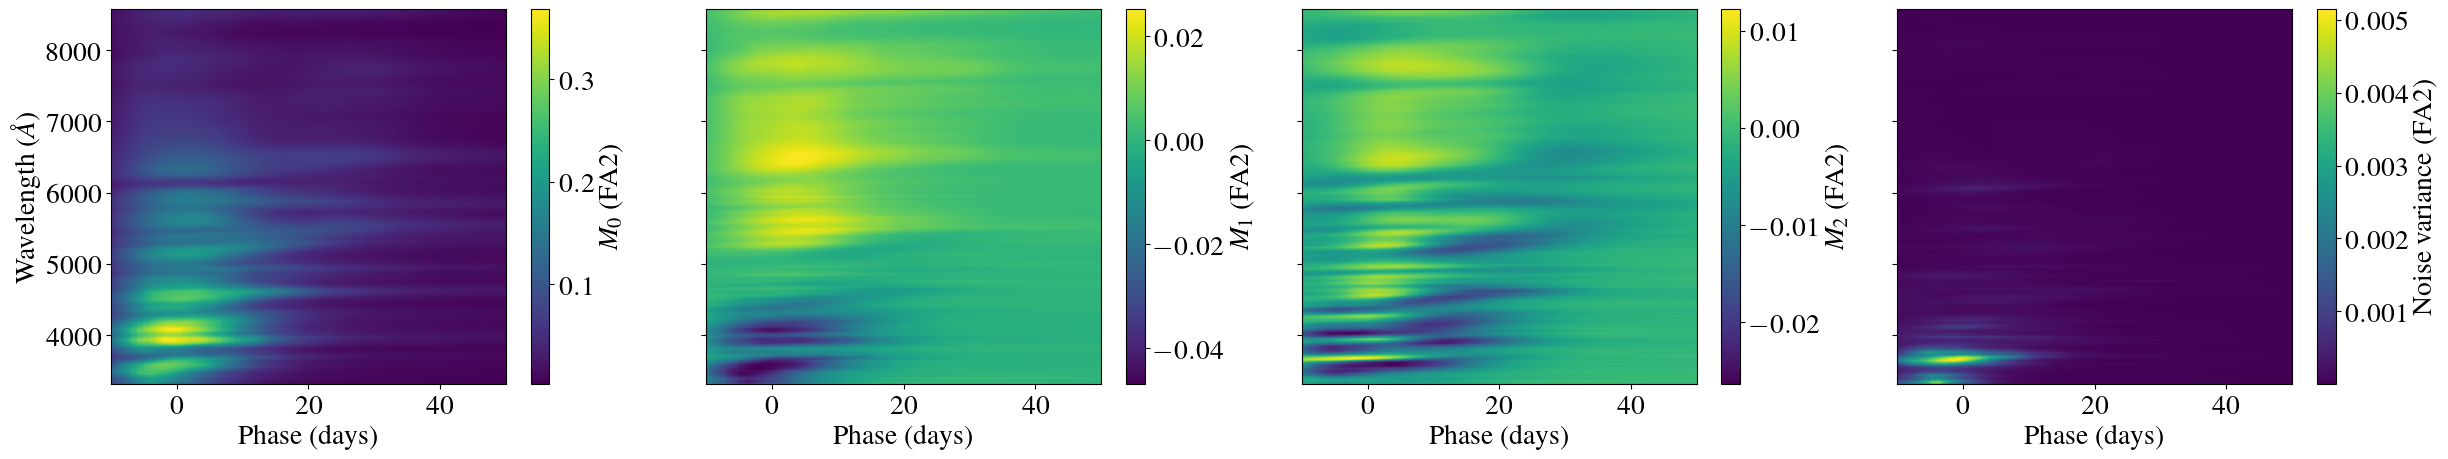

In [31]:
fig, axs = plt.subplots(1,4,figsize=(25,5),sharey=True)

im1 = axs[0].imshow(M_fa2[0].reshape(X.shape),aspect='auto', extent=[p_grid[0], p_grid[-1], w_grid_reg[0],w_grid_reg[-1]],  origin='lower',vmax=M_fa2[0].max(), vmin=M_fa2[0].min())
axs[0].set_xlabel("Phase (days)")
axs[0].set_ylabel(r"Wavelength ($\AA$)")
fig.colorbar(im1,ax=axs[0],label=r"$M_0$ (FA2)")
im2 = axs[1].imshow(M_fa2[1].reshape(X.shape),aspect='auto', extent=[p_grid[0], p_grid[-1], w_grid_reg[0],w_grid_reg[-1]],  origin='lower',vmax=M_fa2[1].max(), vmin=M_fa2[1].min())
axs[1].set_xlabel("Phase (days)")
fig.colorbar(im2,ax=axs[1],label=r"$M_1$ (FA2)")
im3 = axs[2].imshow(M_fa2[2].reshape(X.shape),aspect='auto', extent=[p_grid[0], p_grid[-1], w_grid_reg[0],w_grid_reg[-1]],  origin='lower',vmax=M_fa2[2].max(), vmin=M_fa2[2].min())
axs[2].set_xlabel("Phase (days)")
fig.colorbar(im3,ax=axs[2],label=r"$M_2$ (FA2)")
im4 = axs[3].imshow(noise_var_fa2.reshape(X.shape),aspect='auto', extent=[p_grid[0], p_grid[-1], w_grid_reg[0],w_grid_reg[-1]],  origin='lower',vmax=noise_var_fa2.max(), vmin=noise_var_fa2.min())
axs[3].set_xlabel("Phase (days)")
fig.colorbar(im4,ax=axs[3],label=r"Noise variance  (FA2)")

fig.tight_layout()
plt.savefig('./fa_figures/FA_components_2d.png',dpi=300,facecolor='white', transparent=False,bbox_inches='tight')  

## View CSP Filters

In [32]:
filters=["cspg","cspr","cspv9844"]

In [33]:
filters_label=["CSP-G","CSP-R","CSP-V9844"]

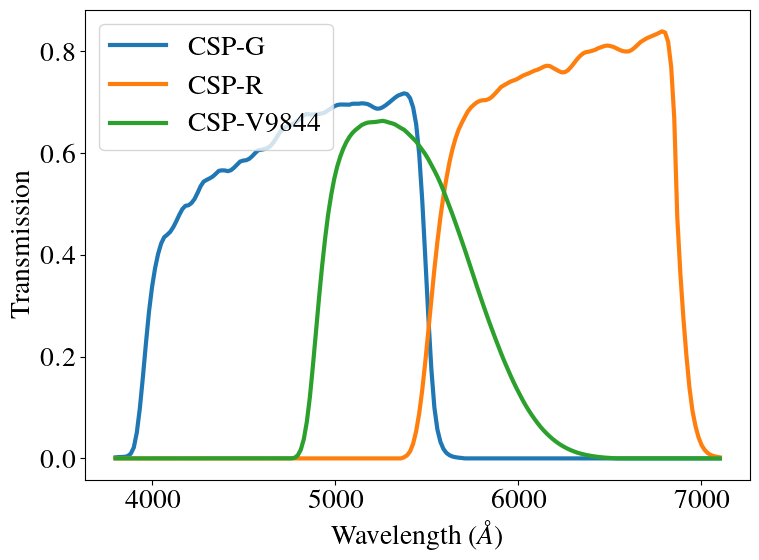

In [34]:
fig=plt.figure(figsize=(8,6))
colors=["C0","C1","C2"]
for j,f in enumerate(filters):
    plt.plot(np.linspace(3800,7100,200),sncosmo.get_bandpass(f)(np.linspace(3800,7100,200)),label=filters_label[j],lw=3,color=colors[j])
plt.xlabel("Wavelength ($\\AA$)")
plt.ylabel("Transmission")
plt.legend(loc=2)
fig.tight_layout()
plt.savefig('./fa_figures/validation_fits_filters.png',facecolor='white')  
# Default unit transmission in sncosmo: ratio of transmitted to incident photons.

In [35]:
csp=sncosmo.get_magsystem("csp")

## Create SNCOSMO PETS Class

In [36]:
class PETS5(sncosmo.Source):
    
    _param_names = ['x0', 'x1', 'x2','x3','x4','x5']
    param_names_latex = ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5'] 
    
    def __init__(self, phase, wave, flux0, flux1, flux2, flux3, flux4, flux5, name='PETS', version='2024'):

        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        
        self._model_flux0  = BicubicInterpolator(phase, wave, flux0.T)
        self._model_flux1  = BicubicInterpolator(phase, wave, flux1.T)
        self._model_flux2  = BicubicInterpolator(phase, wave, flux2.T)
        self._model_flux3  = BicubicInterpolator(phase, wave, flux3.T)
        self._model_flux4  = BicubicInterpolator(phase, wave, flux4.T)
        self._model_flux5  = BicubicInterpolator(phase, wave, flux5.T)

        self._parameters = np.array([1,0,0,0,0,0])  # initial guess
        
    def _flux(self, phase, wave):
        x0, x1, x2, x3, x4, x5= self._parameters
        return x0 * (self._model_flux0(phase, wave) +  x1 * self._model_flux1(phase, wave) +  x2 * self._model_flux2(phase, wave)+  x3 * self._model_flux3(phase, wave)+  x4 * self._model_flux4(phase, wave)+  x5 * self._model_flux5(phase, wave))   
    # Para adicionar bandflux relative variance precisaríamos de superfícies com incerteza do modelo. E construir uma matriz ainda maior para incluir a covariância, onde levaríamos tbm em conta os erros de correção K

In [37]:
pets2 = PETS5(p_grid, w_grid_reg, M_fa2[0].reshape(X.shape), M_fa2[1].reshape(X.shape), M_fa2[2].reshape(X.shape), M_fa5[3].reshape(X.shape), M_fa5[4].reshape(X.shape), M_fa5[5].reshape(X.shape))

In [38]:
pets5 = PETS5(p_grid, w_grid_reg, M_fa5[0].reshape(X.shape), M_fa5[1].reshape(X.shape), M_fa5[2].reshape(X.shape), M_fa5[3].reshape(X.shape), M_fa5[4].reshape(X.shape), M_fa5[5].reshape(X.shape))

## Fit Synthetic Photometry

In [39]:
val_data_reshape={}
val_data_err_reshape={}
for i in range(len(val_data)):
    val_data_reshape[i]=val_data[i].reshape(X.shape)
    val_data_err_reshape[i]=val_data_err[i].reshape(X.shape)

In [40]:
chi2red_val_2=[]
chi2red_val_5=[]

In [41]:
train_data_reshape={}
train_data_err_reshape={}
for i in range(len(train_data)):
    train_data_reshape[i]=train_data[i].reshape(X.shape)
    train_data_err_reshape[i]=train_data_err[i].reshape(X.shape)

In [42]:
chi2red_train_2=[]
chi2red_train_5=[]

In [43]:
file_info=[]

In [44]:
for k in range(len(val_data_reshape)):
    print(val_names[k])
    
    fig, axs=plt.subplots(6,1,figsize=(14,14),sharex=True, gridspec_kw={'height_ratios': [5,1,5,1,5,1]})
    fig.subplots_adjust(hspace=0.4)
    colors=["C0","C1","C2","C3"]

    p_random=np.arange(-8,48,4)

    specs=[sncosmo.Spectrum(wave=Y.T[t],flux=val_data_reshape[k].T[t],fluxerr=val_data_err_reshape[k].T[t]) for t in range(len(p_grid))]  
                     
    flux_l=[]
    fluxcov_l=[]
    phase=[]
    filt=[]
    for l in range(len(p_grid)):
        if p_grid[l] in p_random:
            phase.append([p_grid[l]]*len(filters))
            flu_band,cov_band=specs[l].bandfluxcov(filters)
            flux_l.append(flu_band)
            fluxcov_l.append(cov_band)
            filt.append(filters)
        else:
            continue

    cov=block_diag(fluxcov_l[0], fluxcov_l[1], fluxcov_l[2], fluxcov_l[3], fluxcov_l[4], fluxcov_l[5], fluxcov_l[6], fluxcov_l[7], fluxcov_l[8], fluxcov_l[9], fluxcov_l[10], fluxcov_l[11], fluxcov_l[12], fluxcov_l[13])

    tab=Table({"time":np.array(phase).reshape(-1),"flux":np.array(flux_l).reshape(-1),"fluxerr":np.sqrt(cov.diagonal()),"fluxcov":cov.tolist(),"flt":np.array(filt).reshape(-1)})

    zp=[]
    zpsys=[]
    for j in tab["flt"]:
        zp.append(2.5*np.log10(csp.zpbandflux(j)))
        zpsys.append("csp")

    tab.add_column(zp,name="zp")
    tab.add_column(zpsys,name="zpsys")
    
    model2=sncosmo.Model(source=pets2)
    model2.set(z=0.,t0=0.) 
    model5=sncosmo.Model(source=pets5)
    model5.set(z=0.,t0=0.) 
    
    result2, fitted_model2 = sncosmo.fit_lc(tab, model2, ['x0', 'x1', 'x2'],modelcov=False, phase_range=(p_grid[0], p_grid[-1]), wave_range=(w_grid_reg[0],w_grid_reg[-1]), verbose=False)
    result5, fitted_model5= sncosmo.fit_lc(tab, model5, ['x0', 'x1', 'x2', 'x3', 'x4', 'x5'],modelcov=False, phase_range=(p_grid[0], p_grid[-1]), wave_range=(w_grid_reg[0],w_grid_reg[-1]), verbose=False)
    
    chi2red_val_2.append(np.round(result2.chisq/result2.ndof,2))
    chi2red_val_5.append(np.round(result5.chisq/result5.ndof,2)) 

    file_df=pd.DataFrame([result2.parameters[2:],result5.parameters[2:]])
    file_df.columns=["x0","x1","x2","x3","x4","x5"]
    file_df.insert(0,"SN",[f"{val_names[k]}",f"{val_names[k]}"])
    file_df.insert(1,"Model",["PETS-FA2","PETS-FA5"])
    file_df.insert(8,"Type",["Validation","Validation"])
    file_df.insert(9,"Chi2red",[f"{np.round(result2.chisq/result2.ndof,2)}",f"{np.round(result5.chisq/result5.ndof,2)}"])
    
    file_info.append(file_df)

    l=0
    for m,f in enumerate(filters):
        axs[l].errorbar(tab[tab["flt"]==f]["time"], tab[tab["flt"]==f]["flux"]*10**(-0.4*tab[tab["flt"]==f]["zp"]+11), yerr=tab[tab["flt"]==f]["fluxerr"]*10**(-0.4*tab[tab["flt"]==f]["zp"]+11),label="Data",color="black",ls="none",fmt='o')
        axs[l].plot(np.linspace(-10,50,100),fitted_model2.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*tab[tab["flt"]==f]["zp"][0]+11),linewidth=4,color=colors[0],label=r"PETS-FA2 ($\chi^2_\textnormal{red}$"+f"={np.round(result2.chisq/result2.ndof,2)})")
        axs[l].plot(np.linspace(-10,50,100),fitted_model5.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*tab[tab["flt"]==f]["zp"][0]+11),"--",linewidth=4,color=colors[1],label=r"PETS-FA5 ($\chi^2_\textnormal{red}$"+f"={np.round(result5.chisq/result5.ndof,2)})")
        axs[l].set_ylabel(r"Flux $ZP_{AB}=27.5$")
        formatter11=ScalarFormatterClass1()
        formatter11.set_scientific(True)
        formatter11.set_powerlimits((0,0))
        axs[l].yaxis.set_major_formatter(formatter11)
        axs[l].text(0.5,0.9,f'{filters_label[m]} filter', transform=axs[l].transAxes, fontsize=22, va='top', ha='left')
        
        fa_2=interp1d(np.linspace(-10,50,100),fitted_model2.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*tab[tab["flt"]==f]["zp"][0]+11))(tab[tab["flt"]==f]["time"])
        fa_5=interp1d(np.linspace(-10,50,100),fitted_model5.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*tab[tab["flt"]==f]["zp"][0]+11))(tab[tab["flt"]==f]["time"])

        y=tab[tab["flt"]==f]["flux"]*10**(-0.4*tab[tab["flt"]==f]["zp"]+11)
        axs[l+1].scatter(tab[tab["flt"]==f]["time"],(fa_2-tab[tab["flt"]==f]["flux"]*10**(-0.4*tab[tab["flt"]==f]["zp"]+11))/y,marker="s")
        axs[l+1].scatter(tab[tab["flt"]==f]["time"],(fa_5-tab[tab["flt"]==f]["flux"]*10**(-0.4*tab[tab["flt"]==f]["zp"]+11))/y,marker="^")
        axs[l+1].axhline(y=0., color='black', linestyle='--')
        axs[l+1].set_ylabel("residue")

        if l ==0:
            axs[l].legend(loc=1,fontsize=15)        
            axs[l].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        else: pass        
            
        if l==4:
            axs[l+1].set_xlabel("Phase (days)")

        l+=2
    fig.tight_layout()
    plt.savefig(f'./synthetic_photo_fits_fa/validation_set/synt_phot_fit_FA_{val_names[k]}.pdf')#png',dpi=300,facecolor='white', transparent=False,bbox_inches='tight') 
    plt.close(fig)

Train_SN51_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN23_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN44_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN8_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN106_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN78_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN21_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN53_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN39_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN95_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN42_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN121_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN83_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN115_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN116_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN108_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


In [45]:
for k in range(len(train_data_reshape)):
    print(train_names[k])
    
    fig, axs=plt.subplots(6,1,figsize=(14,14),sharex=True, gridspec_kw={'height_ratios': [5,1,5,1,5,1]})
    fig.subplots_adjust(hspace=0.4)
    colors=["C0","C1","C2","C3"]
    
    p_random=np.arange(-8,48,4)

    specs=[sncosmo.Spectrum(wave=Y.T[t],flux=train_data_reshape[k].T[t],fluxerr=train_data_err_reshape[k].T[t]) for t in range(len(p_grid))]  
                     
    flux_l=[]
    fluxcov_l=[]
    phase=[]
    filt=[]
    for l in range(len(p_grid)):
        if p_grid[l] in p_random:
            phase.append([p_grid[l]]*len(filters))
            flu_band,cov_band=specs[l].bandfluxcov(filters)
            flux_l.append(flu_band)
            fluxcov_l.append(cov_band)
            filt.append(filters)
        else:
            continue

    cov=block_diag(fluxcov_l[0], fluxcov_l[1], fluxcov_l[2], fluxcov_l[3], fluxcov_l[4], fluxcov_l[5], fluxcov_l[6], fluxcov_l[7], fluxcov_l[8], fluxcov_l[9], fluxcov_l[10], fluxcov_l[11], fluxcov_l[12], fluxcov_l[13])

    tab=Table({"time":np.array(phase).reshape(-1),"flux":np.array(flux_l).reshape(-1),"fluxerr":np.sqrt(cov.diagonal()),"fluxcov":cov.tolist(),"flt":np.array(filt).reshape(-1)})

    zp=[]
    zpsys=[]
    for j in tab["flt"]:
        zp.append(2.5*np.log10(csp.zpbandflux(j)))
        zpsys.append("csp")

    tab.add_column(zp,name="zp")
    tab.add_column(zpsys,name="zpsys")
    
    model2 = sncosmo.Model(source=pets2)
    model2.set(z=0.,t0=0.) 
    model5 = sncosmo.Model(source=pets5)
    model5.set(z=0.,t0=0.) 
    
    result2, fitted_model2 = sncosmo.fit_lc(tab, model2, ['x0', 'x1', 'x2'],modelcov=False, phase_range=(p_grid[0], p_grid[-1]), wave_range=(w_grid_reg[0],w_grid_reg[-1]), verbose=False)
    result5, fitted_model5= sncosmo.fit_lc(tab, model5, ['x0', 'x1', 'x2', 'x3', 'x4', 'x5'],modelcov=False, phase_range=(p_grid[0], p_grid[-1]), wave_range=(w_grid_reg[0],w_grid_reg[-1]), verbose=False)

    chi2red_train_2.append(np.round(result2.chisq/result2.ndof,2))
    chi2red_train_5.append(np.round(result5.chisq/result5.ndof,2))    
    
    file_df=pd.DataFrame([result2.parameters[2:],result5.parameters[2:]])
    file_df.columns=["x0","x1","x2","x3","x4","x5"]
    file_df.insert(0,"SN",[f"{train_names[k]}",f"{train_names[k]}"])
    file_df.insert(1,"Model",["PETS-FA2","PETS-FA5"])
    file_df.insert(8,"Type",["Training","Training"])
    file_df.insert(9,"Chi2red",[f"{np.round(result2.chisq/result2.ndof,2)}",f"{np.round(result5.chisq/result5.ndof,2)}"])
    
    file_info.append(file_df)

    l=0
    for m,f in enumerate(filters):
        axs[l].errorbar(tab[tab["flt"]==f]["time"], tab[tab["flt"]==f]["flux"]*10**(-0.4*tab[tab["flt"]==f]["zp"]+11), yerr=tab[tab["flt"]==f]["fluxerr"]*10**(-0.4*tab[tab["flt"]==f]["zp"]+11),label="Data",color="black",ls="none",fmt='o')
        axs[l].plot(np.linspace(-10,50,100),fitted_model2.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*tab[tab["flt"]==f]["zp"][0]+11),linewidth=4,color=colors[0],label=r"PETS-FA2 ($\chi^2_\textnormal{red}$"+f"={np.round(result2.chisq/result2.ndof,2)})")
        axs[l].plot(np.linspace(-10,50,100),fitted_model5.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*tab[tab["flt"]==f]["zp"][0]+11),"--",linewidth=4,color=colors[1],label=r"PETS-FA5 ($\chi^2_\textnormal{red}$"+f"={np.round(result5.chisq/result5.ndof,2)})")
        axs[l].set_ylabel(r"Flux $ZP_{AB}=27.5$")
        formatter11=ScalarFormatterClass1()
        formatter11.set_scientific(True)
        formatter11.set_powerlimits((0,0))
        axs[l].yaxis.set_major_formatter(formatter11)
        axs[l].text(0.5,0.9,f'{filters_label[m]} filter', transform=axs[l].transAxes, fontsize=22, va='top', ha='left')
        
        fa_2=interp1d(np.linspace(-10,50,100),fitted_model2.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*tab[tab["flt"]==f]["zp"][0]+11))(tab[tab["flt"]==f]["time"])
        fa_5=interp1d(np.linspace(-10,50,100),fitted_model5.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*tab[tab["flt"]==f]["zp"][0]+11))(tab[tab["flt"]==f]["time"])

        y=tab[tab["flt"]==f]["flux"]*10**(-0.4*tab[tab["flt"]==f]["zp"]+11)
        axs[l+1].scatter(tab[tab["flt"]==f]["time"],(fa_2-tab[tab["flt"]==f]["flux"]*10**(-0.4*tab[tab["flt"]==f]["zp"]+11))/y,marker="s")
        axs[l+1].scatter(tab[tab["flt"]==f]["time"],(fa_5-tab[tab["flt"]==f]["flux"]*10**(-0.4*tab[tab["flt"]==f]["zp"]+11))/y,marker="^")
        axs[l+1].axhline(y=0., color='black', linestyle='--')
        axs[l+1].set_ylabel("residue")

        if l ==0:
            axs[l].legend(loc=1,fontsize=15)        
            axs[l].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        else: pass        
            
        if l==4:
            axs[l+1].set_xlabel("Phase (days)")

        l+=2
    fig.tight_layout()
    plt.savefig(f'./synthetic_photo_fits_fa/training_set/synt_phot_fit_FA_{train_names[k]}.pdf')#png',dpi=300,facecolor='white', transparent=False,bbox_inches='tight') 
    plt.close(fig)

Test_SN2_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN6_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN68_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN29_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN37_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN20_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN90_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN105_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN55_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN3_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN9_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN47_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN56_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN94_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN32_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN5_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN62_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN24_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN91_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN52_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN7_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN43_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN18_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN46_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN69_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN99_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN54_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN101_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN21_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN17_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN19_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN67_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN82_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN11_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN73_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN77_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN8_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN76_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN38_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN49_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN19_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN9_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN58_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN43_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN63_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN74_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN35_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN7_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN10_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN11_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN25_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN80_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN47_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN119_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN0_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN104_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN111_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN60_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN87_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN86_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN14_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN1_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN31_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN117_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN59_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN1_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN37_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN33_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN48_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN79_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN102_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN103_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN38_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN16_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN107_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN20_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN39_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN84_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN114_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN41_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN45_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN5_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN25_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN3_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN36_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN12_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN30_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN81_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN109_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN27_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN71_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN4_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN113_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN34_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN120_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN2_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN92_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN97_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN40_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN6_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN61_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN0_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN112_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN46_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN28_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN16_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN48_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN13_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN35_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN70_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN57_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN41_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN18_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN89_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN13_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN14_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN88_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN75_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN118_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN110_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN66_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN12_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN27_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN4_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN32_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN50_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN29_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN85_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN65_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN22_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN24_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN17_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN10_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN98_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN22_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN26_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN100_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN28_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN31_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN42_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN72_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN40_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN36_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN64_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN33_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN44_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN45_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN23_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN15_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN34_v2_SED_normalized


/home/cassia/anaconda3/envs/sne2/lib/python3.12/site-packages/iminuit/util.py:175: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


In [46]:
file_info_concat=pd.concat(file_info,ignore_index=True)

In [47]:
file_info_concat.to_csv("./synthetic_photo_fits_fa/fit_results.dat",sep=" ",index=False)

## Analyse Fit $\chi^2_{red}$ Distributions

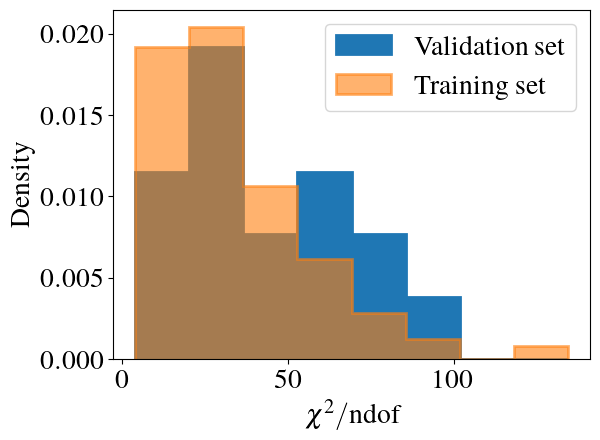

In [48]:
bins=np.histogram(np.hstack((chi2red_val_2,chi2red_train_2)), bins=8)[1]
plt.hist(chi2red_val_2,bins=bins,density=True,label="Validation set",fill=True, histtype='step',lw=2.)
plt.hist(chi2red_train_2,bins=bins,density=True,label="Training set",fill=True, histtype='step',lw=2.,alpha=0.6)
plt.xlabel(r"$\chi^2/\textnormal{ndof}$")
plt.ylabel("Density")
#plt.title("PETS-FA2")
plt.legend()
plt.tight_layout()
plt.savefig(f'./synthetic_photo_fits_fa/chi2_pets_fa2.png',facecolor='white');

In [49]:
ks_2samp(chi2red_val_2,chi2red_train_2)

KstestResult(statistic=0.25083333333333335, pvalue=0.2727765030842178, statistic_location=50.82, statistic_sign=-1)

In [50]:
print("PETS-FA2 - Fraction of chi2red<30:")
print(f"Validation set: {len([i for i in chi2red_val_2 if i<30])/len(chi2red_val_2)}")
print(f"Training set: {len([i for i in chi2red_train_2 if i<30])/len(chi2red_train_2)}")
print("\n")
print("PETS-FA2 - Fraction of chi2red<100:")
print(f"Validation set: {len([i for i in chi2red_val_2 if i<100])/len(chi2red_val_2)}")
print(f"Training set: {len([i for i in chi2red_train_2 if i<100])/len(chi2red_train_2)}")
print("\n")
print("PETS-FA2 - Fraction of chi2red<200:")
print(f"Validation set: {len([i for i in chi2red_val_2 if i<200])/len(chi2red_val_2)}")
print(f"Training set: {len([i for i in chi2red_train_2 if i<200])/len(chi2red_train_2)}")

PETS-FA2 - Fraction of chi2red<30:
Validation set: 0.375
Training set: 0.5266666666666666


PETS-FA2 - Fraction of chi2red<100:
Validation set: 1.0
Training set: 0.9866666666666667


PETS-FA2 - Fraction of chi2red<200:
Validation set: 1.0
Training set: 1.0


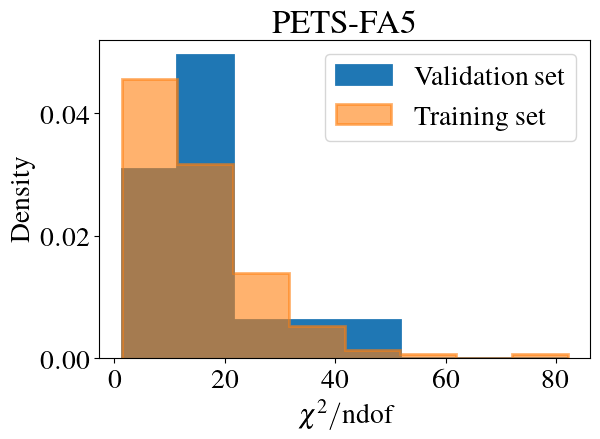

In [51]:
bins=np.histogram(np.hstack((chi2red_val_5,chi2red_train_5)), bins=8)[1]
plt.hist(chi2red_val_5,bins=bins,density=True,label="Validation set",fill=True, histtype='step',lw=2.)
plt.hist(chi2red_train_5,bins=bins,density=True,label="Training set",fill=True, histtype='step',lw=2.,alpha=0.6)
plt.xlabel(r"$\chi^2/\textnormal{ndof}$")
plt.ylabel("Density")
plt.title("PETS-FA5")
plt.legend()
plt.tight_layout()
plt.savefig(f'./synthetic_photo_fits_fa/chi2_pets_fa5.png',facecolor='white');

In [52]:
ks_2samp(chi2red_val_5,chi2red_train_5)

KstestResult(statistic=0.19666666666666666, pvalue=0.5622278413948988, statistic_location=10.45, statistic_sign=-1)

In [53]:
print("PETS-FA5 - Fraction of chi2red<30:")
print(f"Validation set: {len([i for i in chi2red_val_5 if i<30])/len(chi2red_val_5)}")
print(f"Training set: {len([i for i in chi2red_train_5 if i<30])/len(chi2red_train_5)}")
print("\n")
print("PETS-FA5 - Fraction of chi2red<100:")
print(f"Validation set: {len([i for i in chi2red_val_5 if i<100])/len(chi2red_val_5)}")
print(f"Training set: {len([i for i in chi2red_train_5 if i<100])/len(chi2red_train_5)}")
print("\n")
print("PETS-FA5 - Fraction of chi2red<200:")
print(f"Validation set: {len([i for i in chi2red_val_5 if i<200])/len(chi2red_val_5)}")
print(f"Training set: {len([i for i in chi2red_train_5 if i<200])/len(chi2red_train_5)}")

PETS-FA5 - Fraction of chi2red<30:
Validation set: 0.8125
Training set: 0.8933333333333333


PETS-FA5 - Fraction of chi2red<100:
Validation set: 1.0
Training set: 1.0


PETS-FA5 - Fraction of chi2red<200:
Validation set: 1.0
Training set: 1.0


## Analyse Fit Parameters Distributions

In [54]:
FA2_VAL=file_info_concat[(file_info_concat["Model"]=="PETS-FA2") & (file_info_concat["Type"]=="Validation")]
FA2_TRAIN=file_info_concat[(file_info_concat["Model"]=="PETS-FA2") & (file_info_concat["Type"]=="Training")]

In [55]:
x1_val_FA2=np.percentile(FA2_VAL[abs(FA2_VAL["x1"])<10.]["x1"],[5,50,95])
x2_val_FA2=np.percentile(FA2_VAL[abs(FA2_VAL["x2"])<10.]["x2"],[5,50,95])

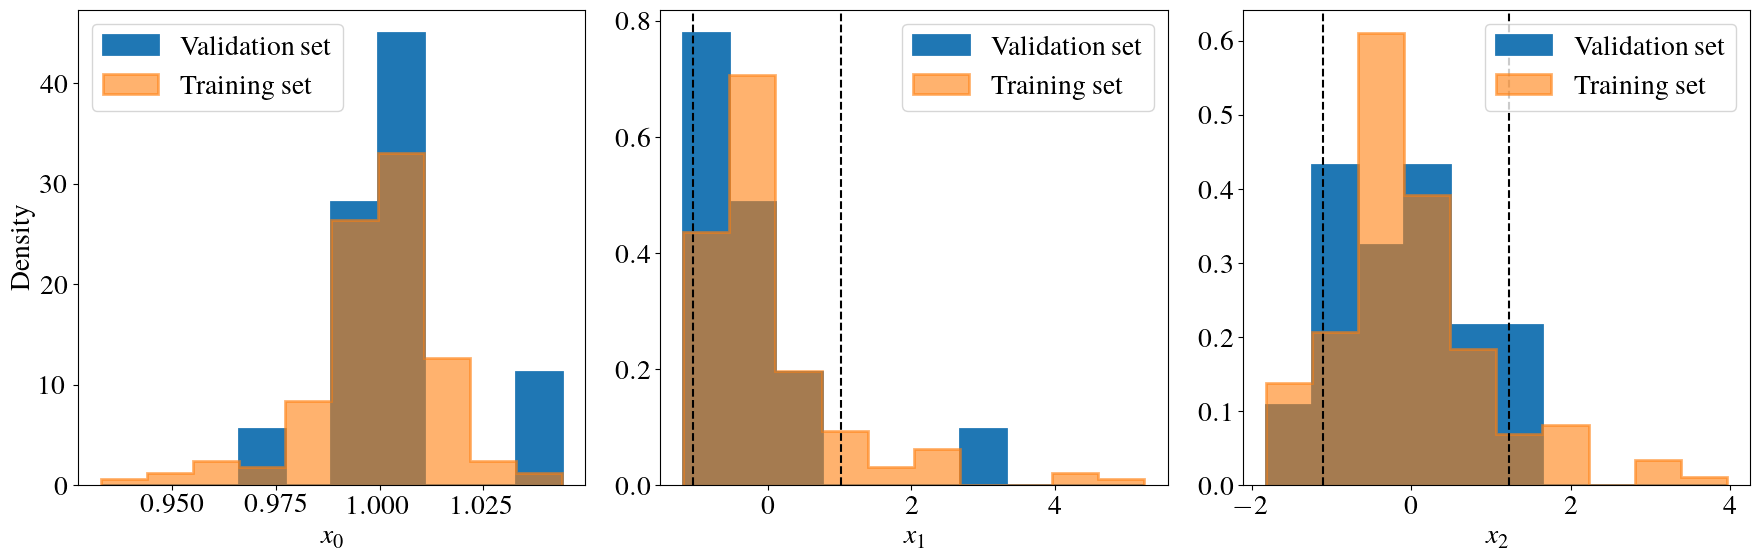

In [69]:
fig, axs = plt.subplots(1,3,figsize=(18,6))

bins0=np.histogram(np.hstack((FA2_VAL["x0"].values,FA2_TRAIN["x0"].values)), bins=10)[1]
axs[0].hist(FA2_VAL["x0"].values,bins=bins0,density=True,label="Validation set",fill=True, histtype='step',lw=2.)
axs[0].hist(FA2_TRAIN["x0"].values,bins=bins0,density=True,label="Training set",fill=True, histtype='step',lw=2.,alpha=0.6)
axs[0].set_xlabel(r"$x_0$")
axs[0].set_ylabel("Density")
axs[0].legend(loc=2)

bins1=np.histogram(np.hstack((FA2_VAL["x1"].values,FA2_TRAIN["x1"].values)), bins=10)[1]
axs[1].hist(FA2_VAL["x1"].values,bins=bins1,density=True,label="Validation set",fill=True, histtype='step',lw=2.)
axs[1].hist(FA2_TRAIN["x1"].values,bins=bins1,density=True,label="Training set",fill=True, histtype='step',lw=2.,alpha=0.6)
axs[1].set_xlabel(r"$x_1$")
axs[1].axvline(x1_val_FA2[0],ls='--',c="black")
axs[1].axvline(x1_val_FA2[2],ls='--',c="black")
axs[1].legend()

bins2=np.histogram(np.hstack((FA2_VAL["x2"].values,FA2_TRAIN["x2"].values)), bins=10)[1]
axs[2].hist(FA2_VAL["x2"].values,bins=bins2,density=True,label="Validation set",fill=True, histtype='step',lw=2.)
axs[2].hist(FA2_TRAIN["x2"].values,bins=bins2,density=True,label="Training set",fill=True, histtype='step',lw=2.,alpha=0.6)
axs[2].axvline(x2_val_FA2[0],ls='--',c="black")
axs[2].axvline(x2_val_FA2[2],ls='--',c="black")
axs[2].set_xlabel(r"$x_2$")
axs[2].legend()

#plt.suptitle("PETS-FA2")
fig.tight_layout()
plt.savefig(f'./synthetic_photo_fits_fa/par_dist_pets_fa2.png',facecolor='white');

In [57]:
ks_2samp(FA2_VAL["x0"].values,FA2_TRAIN["x0"].values)

KstestResult(statistic=0.195, pvalue=0.5724977479174723, statistic_location=0.9952425331549325, statistic_sign=-1)

In [58]:
ks_2samp(FA2_VAL["x1"].values,FA2_TRAIN["x1"].values)

KstestResult(statistic=0.24666666666666667, pvalue=0.2899067921736698, statistic_location=-0.5746681813133572, statistic_sign=1)

In [59]:
ks_2samp(FA2_VAL["x2"].values,FA2_TRAIN["x2"].values)

KstestResult(statistic=0.13833333333333334, pvalue=0.9063684480274863, statistic_location=-0.17973586134220237, statistic_sign=-1)

In [60]:
# p abaixo de 0.05, as amostras não vieram da mesma distribuição

In [61]:
FA5_VAL=file_info_concat[(file_info_concat["Model"]=="PETS-FA5") & (file_info_concat["Type"]=="Validation")]
FA5_TRAIN=file_info_concat[(file_info_concat["Model"]=="PETS-FA5") & (file_info_concat["Type"]=="Training")]

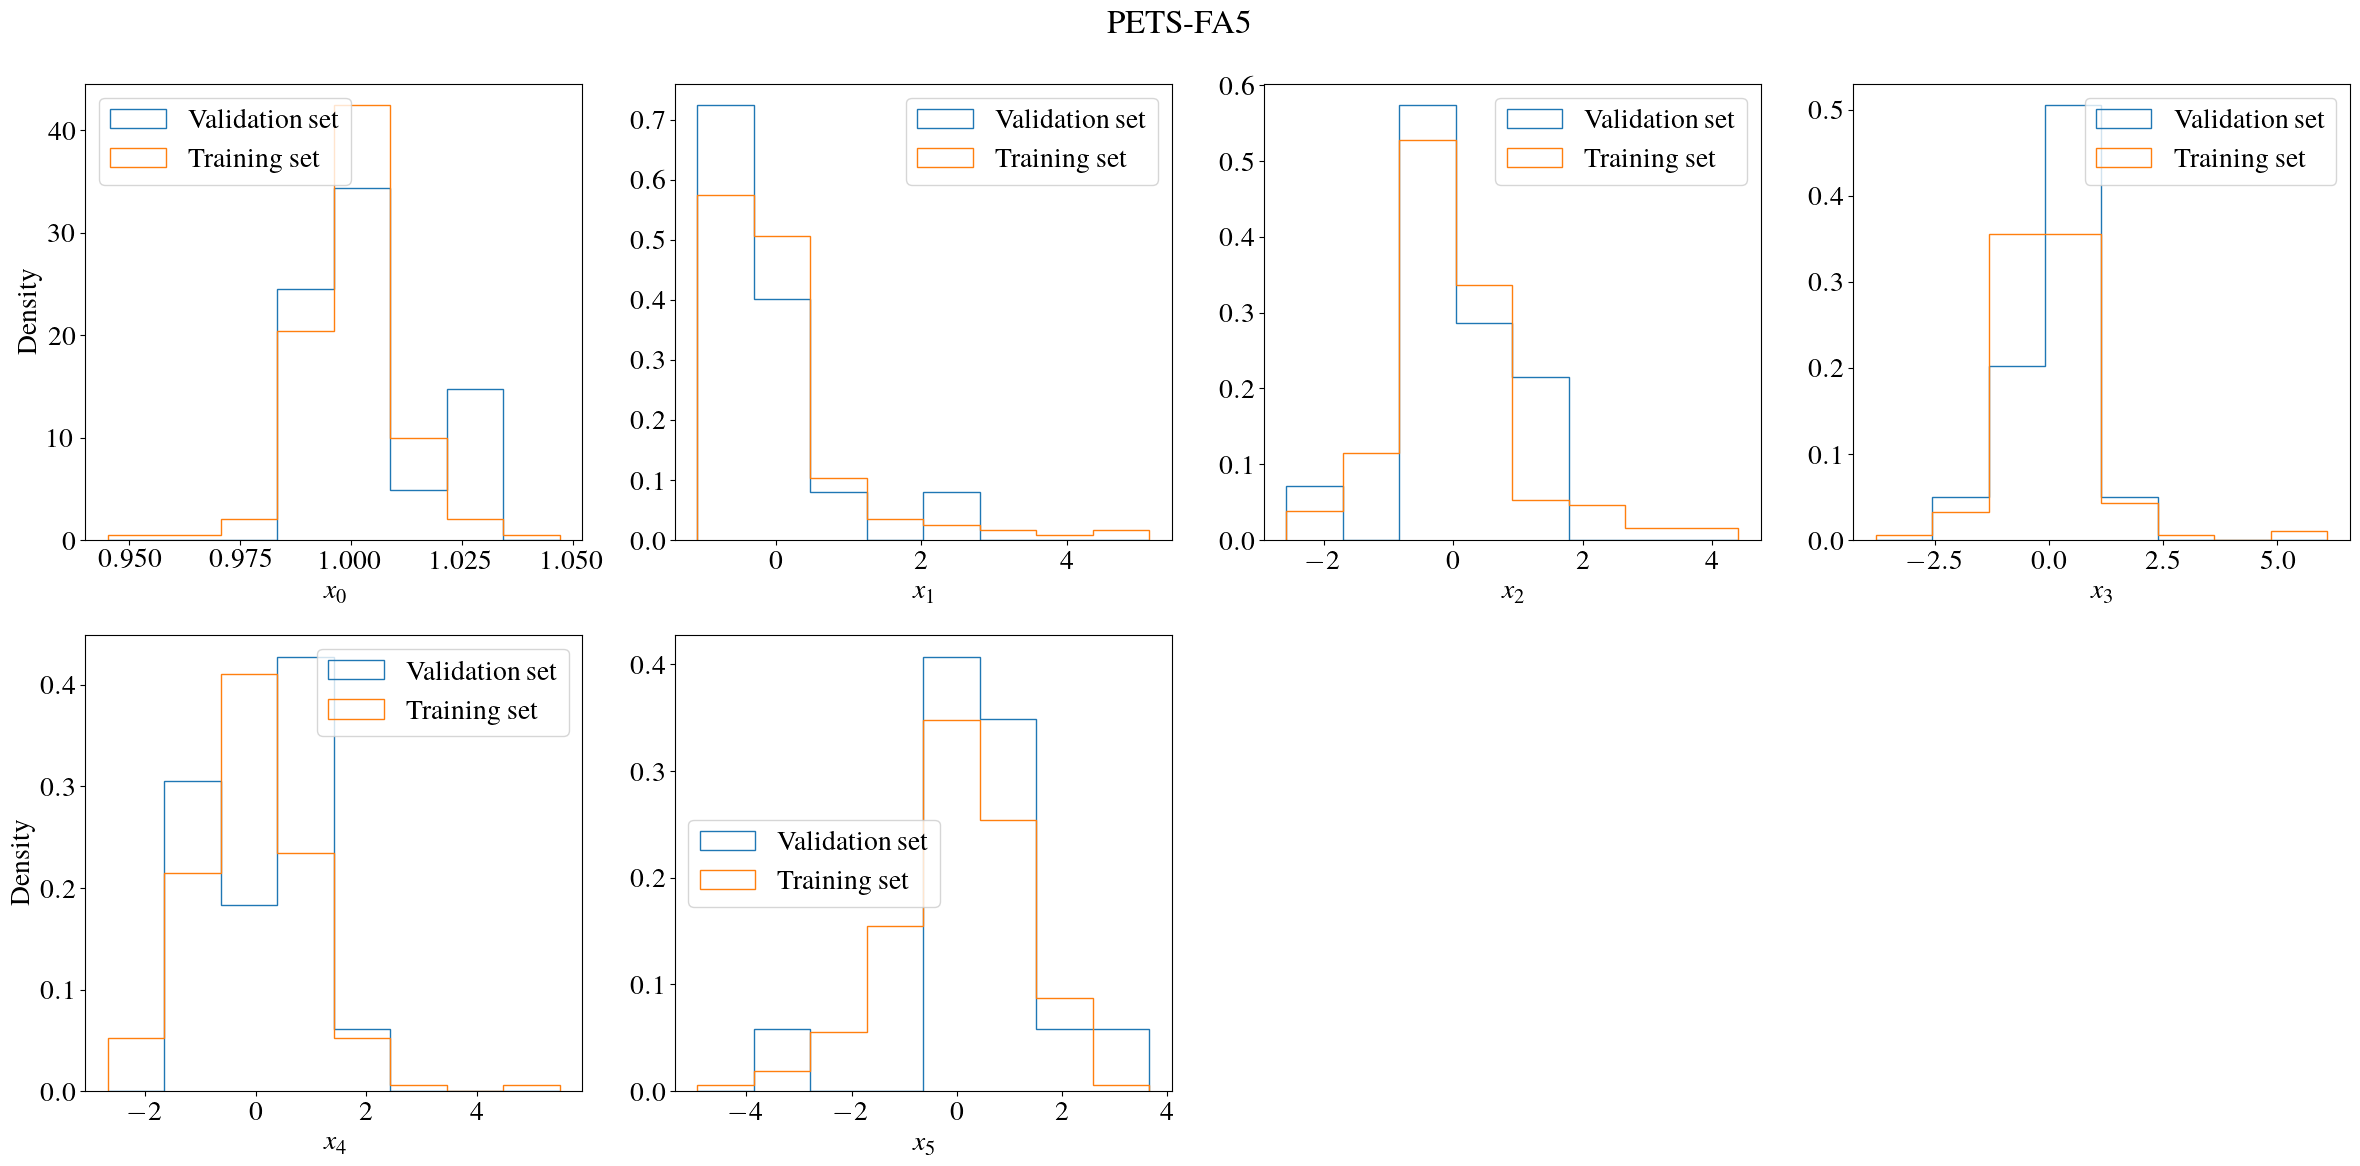

In [62]:
fig, axs = plt.subplots(2,4,figsize=(24,12))

bins0=np.histogram(np.hstack((FA5_VAL["x0"].values,FA5_TRAIN["x0"].values)), bins=8)[1]
axs[0,0].hist(FA5_VAL["x0"].values,bins=bins0,density=True,label="Validation set",fill=False, histtype='step')
axs[0,0].hist(FA5_TRAIN["x0"].values,bins=bins0,density=True,label="Training set",fill=False, histtype='step')
axs[0,0].set_xlabel(r"$x_0$")
axs[0,0].set_ylabel("Density")
axs[0,0].legend()

bins1=np.histogram(np.hstack((FA5_VAL["x1"].values,FA5_TRAIN["x1"].values)), bins=8)[1]
axs[0,1].hist(FA5_VAL["x1"].values,bins=bins1,density=True,label="Validation set",fill=False, histtype='step')
axs[0,1].hist(FA5_TRAIN["x1"].values,bins=bins1,density=True,label="Training set",fill=False, histtype='step')
axs[0,1].set_xlabel(r"$x_1$")
axs[0,1].legend()

bins2=np.histogram(np.hstack((FA5_VAL["x2"].values,FA5_TRAIN["x2"].values)), bins=8)[1]
axs[0,2].hist(FA5_VAL["x2"].values,bins=bins2,density=True,label="Validation set",fill=False, histtype='step')
axs[0,2].hist(FA5_TRAIN["x2"].values,bins=bins2,density=True,label="Training set",fill=False, histtype='step')
axs[0,2].set_xlabel(r"$x_2$")
axs[0,2].legend()

bins3=np.histogram(np.hstack((FA5_VAL["x3"].values,FA5_TRAIN["x3"].values)), bins=8)[1]
axs[0,3].hist(FA5_VAL["x3"].values,bins=bins3,density=True,label="Validation set",fill=False, histtype='step')
axs[0,3].hist(FA5_TRAIN["x3"].values,bins=bins3,density=True,label="Training set",fill=False, histtype='step')
axs[0,3].set_xlabel(r"$x_3$")
axs[0,3].legend()

bins4=np.histogram(np.hstack((FA5_VAL["x4"].values,FA5_TRAIN["x4"].values)), bins=8)[1]
axs[1,0].hist(FA5_VAL["x4"].values,bins=bins4,density=True,label="Validation set",fill=False, histtype='step')
axs[1,0].hist(FA5_TRAIN["x4"].values,bins=bins4,density=True,label="Training set",fill=False, histtype='step')
axs[1,0].set_ylabel("Density")
axs[1,0].set_xlabel(r"$x_4$")
axs[1,0].legend()

bins5=np.histogram(np.hstack((FA5_VAL["x5"].values,FA5_TRAIN["x5"].values)), bins=8)[1]
axs[1,1].hist(FA5_VAL["x5"].values,bins=bins5,density=True,label="Validation set",fill=False, histtype='step')
axs[1,1].hist(FA5_TRAIN["x5"].values,bins=bins5,density=True,label="Training set",fill=False, histtype='step')
axs[1,1].set_xlabel(r"$x_5$")
axs[1,1].legend()

axs[1,2].remove()
axs[1,3].remove()
plt.suptitle("PETS-FA5")

fig.tight_layout()
plt.savefig(f'./synthetic_photo_fits_fa/par_dist_pets_fa5.png',facecolor='white');

In [63]:
ks_2samp(FA5_VAL["x0"].values,FA5_TRAIN["x0"].values)

KstestResult(statistic=0.17416666666666666, pvalue=0.7053461961804633, statistic_location=1.0223375968226462, statistic_sign=-1)

In [64]:
ks_2samp(FA5_VAL["x1"].values,FA5_TRAIN["x1"].values)

KstestResult(statistic=0.23083333333333333, pvalue=0.36527306468605186, statistic_location=-0.599525893635253, statistic_sign=1)

In [65]:
ks_2samp(FA5_VAL["x2"].values,FA5_TRAIN["x2"].values)

KstestResult(statistic=0.15166666666666667, pvalue=0.8413546372293408, statistic_location=-0.08672234142035318, statistic_sign=-1)

In [66]:
ks_2samp(FA5_VAL["x3"].values,FA5_TRAIN["x3"].values)

KstestResult(statistic=0.22583333333333333, pvalue=0.3910552068840764, statistic_location=-0.21398926796319315, statistic_sign=-1)

In [67]:
ks_2samp(FA5_VAL["x4"].values,FA5_TRAIN["x4"].values)

KstestResult(statistic=0.29333333333333333, pvalue=0.134070648150448, statistic_location=0.6427018379535141, statistic_sign=-1)

In [68]:
ks_2samp(FA5_VAL["x5"].values,FA5_TRAIN["x5"].values)

KstestResult(statistic=0.355, pvalue=0.03884988764859198, statistic_location=-0.019737767907102206, statistic_sign=-1)